In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from torch import nn
import json
from numpy.random import shuffle
import torch
import torch.optim as optim
import os, sys
from time import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
with open('lookup.json') as fl:
    tag_lookup = json.load(fl)
    
with open('word_list.txt') as fl:
    vocab = fl.read().split('\n')

embeds = np.load('word_embeds.npy')
wlookup = { word: index for index, word in enumerate(vocab) }

len(vocab), embeds.shape, len(tag_lookup)

(23625, (23625, 300), 8)

In [5]:
np.max(embeds[wlookup['Japan']]), np.max(embeds[wlookup['Russia']])

(0.376953125, 0.48046875)

In [16]:
with open('eng.train') as fl:
    sents = fl.read().split('\n\n')[1:-1]
    
with open('eng.testa') as fl:
    eval_sents = fl.read().split('\n\n')[1:-1]
    
with open('eng.testb') as fl:
    test_sents = fl.read().split('\n\n')[1:-1]
    
len(sents), len(eval_sents), len(test_sents)

(14986, 3465, 3683)

### Function to generate the (embedded representation, 1-hot target predictions) for a given sentence

In [7]:
def load_sent(sent):
    words = sent.split('\n')
    inps = []
    outs = []
    for wordinfo in words:
        word, _, _, tag = wordinfo.split()
        try:
            assert word in wlookup
        except:
            # word not in our known dictionary, so use the unk token
            word = 'unk'
        inps.append(embeds[wlookup[word]])
        hot = np.zeros(len(tag_lookup))
        hot[tag_lookup[tag]] = 1
        outs.append(hot)
    return [np.vstack(inps), np.vstack(outs)]

ins, outs = load_sent(sents[0])
ins.shape, outs

((9, 300), array([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.]]))

In [8]:
BSIZE = 1
train_inds = list(range(len(sents)))
shuffle(train_inds)
train_inds[:10]

[8586, 13865, 7536, 11563, 9630, 1118, 3575, 13496, 13953, 1284]

In [9]:
class RNN(nn.Module):
    def __init__(self, insize=300, outsize=8, hsize=128):
        super().__init__()
        
        # TODO: Dropout
        # TODO: nonlinearities
        # TODO: Bidirectional

        self.hsize = hsize
        self.inp = nn.Sequential(
            nn.Linear(insize, hsize),
        )
        self.out = nn.Sequential(
            nn.Linear(hsize, outsize),
            nn.Softmax(dim=-1),
        )

        # FIXME: this is a uni-directional LSTM
        self.rnn = nn.LSTM(hsize, hsize, 1, batch_first=True)

    def forward(self, inputs, hidden=None):
        hin = self.inp(inputs)
        
        hout, hidden = self.rnn(hin)
        
        yout = self.out(hout)
        
        return yout, hidden
    
model = RNN().to(device)
criterion = nn.MSELoss().cuda()
opt = optim.Adam(model.parameters(), lr=0.0005)
# sch = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.5)

In [19]:
EPS = 3
train_loss = []
eval_loss = []
n2t = lambda narr: torch.from_numpy(narr).to(device).float()

def eval_model(evaldata, results=False):
    model.eval()
    losses = []
    ypreds = []
    for sent in evaldata:
        Xs, Ys = zip(*[load_sent(sent)])
        Xs, Ys = np.array(Xs), np.array(Ys)
        Xs, Ys = n2t(Xs), n2t(Ys)
        
        with torch.no_grad():
            yhat, _ = model(Xs)
            ypreds.append(yhat)
            loss = criterion(yhat, Ys)
            losses.append(loss.item())
    print('Eval: %.4f' % np.mean(losses))
    
    if results: 
        return ypreds
    else:
        return np.mean(losses)
    
eval_model(eval_sents)

for epoch in range(EPS):
    model.train()
    t0 = time()
    for bi in range(0, len(train_inds)-BSIZE, BSIZE):
        inds = train_inds[bi:bi+BSIZE]

        # TODO: correct formatting for batchsize >1
        Xs, Ys = zip(*[load_sent(sents[ind]) for ind in inds])
        Xs, Ys = np.array(Xs), np.array(Ys)
        Xs, Ys = n2t(Xs), n2t(Ys)
        # shape: (batch x seqlen x dim)

        yhat, _ = model(Xs)

        opt.zero_grad()
        loss = criterion(yhat, Ys)
        loss.backward()
        opt.step()

        sys.stdout.write('\r[E%d/%d - B%d/%d] Train: %.4f ' % (
            epoch+1, EPS,
            bi+1, len(train_inds),
            loss.item(),
        ))
        train_loss.append(loss.item())
    sys.stdout.write('(elapsed: %.2fs)\n' % (time() - t0))
    sys.stdout.flush()
    
    loss = eval_model()
    eval_loss.append(loss)
        
    shuffle(train_inds)
    # TODO: shuffle train inds

Eval: 0.0108
[E1/3 - B343/14986] Train: 0.0001 

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt

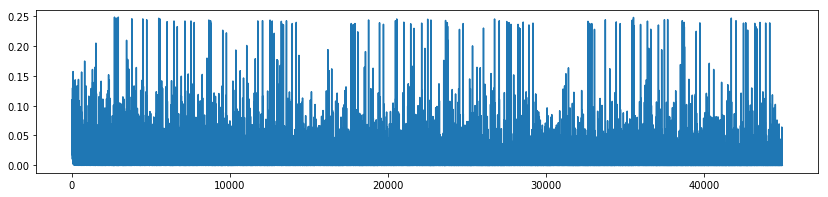

In [12]:
plt.figure(figsize=(14, 3))
plt.plot(train_loss)
plt.show(); plt.close()

In [20]:
test_results = eval_model(test_sents, results=True)

Eval: 0.0184


In [30]:
index2tag = { index: tag for tag, index in tag_lookup.items() }
with open('nn.output' , 'w') as fl:
    assert len(test_results) == len(test_sents)
    for ti, (yhat, schunk) in enumerate(zip(test_results, test_sents)):
        yhat = yhat.detach().cpu().numpy()
        for wi, wordinfo in enumerate(schunk.split('\n')):
            word, _, _, tag = wordinfo.split()
            taghat = index2tag[np.argmax(yhat[0, wi, :])]

            fl.write('%s %s %s\n' % (word, taghat, tag))
        fl.write('\n')

In [31]:
!python conlleval.py nn.output

processed 46665 tokens with 4681 phrases; found: 5648 phrases; correct: 3340.
accuracy:  93.24%; precision:  59.14%; recall:  71.35%; FB1:  64.67
              LOC: precision:  77.04%; recall:  79.86%; FB1:  78.43  1668
             MISC: precision:  62.25%; recall:  66.21%; FB1:  64.17  702
              ORG: precision:  50.93%; recall:  61.48%; FB1:  55.71  1661
              PER: precision:  47.74%; recall:  74.52%; FB1:  58.20  1617
